In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm
import torchaudio.transforms as T
from torch.utils.data import TensorDataset, DataLoader
import random
from torch.nn.utils import clip_grad_norm_
import librosa

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
dataset_speech = torchaudio.datasets.SPEECHCOMMANDS('./', download=True)

100%|██████████| 2.26G/2.26G [01:45<00:00, 23.1MB/s]


In [5]:
def data_extractor(dataset, num_samples=5000, validation_split=0.2):

    trigger_samples = []
    non_trigger_samples = []

    # Extract samples
    for i in range(num_samples):
        waveform, sample_rate, label, *rest = dataset[i]
        if label == 'backward':
            trigger_samples.append((waveform, sample_rate, label))
        else:
            non_trigger_samples.append((waveform, sample_rate, label))

    # Split data into training and validation sets
    num_val_trigger = int(len(trigger_samples) * validation_split)
    num_val_non_trigger = int(len(non_trigger_samples) * validation_split)

    train_trigger_samples = trigger_samples[num_val_trigger:]
    val_trigger_samples = trigger_samples[:num_val_trigger]

    train_non_trigger_samples = non_trigger_samples[num_val_non_trigger:]
    val_non_trigger_samples = non_trigger_samples[:num_val_non_trigger]

    return (train_trigger_samples, train_non_trigger_samples), (val_trigger_samples, val_non_trigger_samples)

In [6]:
(train_trigger_samples, train_non_trigger_samples), (val_trigger_samples, val_non_trigger_samples) = data_extractor(dataset_speech)

In [7]:
print(f"Number of train trigger samples: {len(train_trigger_samples)}")
print(f"Number of train non-trigger samples: {len(train_non_trigger_samples)}")
print(f'Number of val trigger samples: {len(val_trigger_samples)}')
print(f'Number of val non-trigger samples: {len(val_non_trigger_samples)}')

Number of train trigger samples: 1332
Number of train non-trigger samples: 2669
Number of val trigger samples: 332
Number of val non-trigger samples: 667


In [8]:
lab = train_non_trigger_samples[410]
lab

(tensor([[0.0050, 0.0071, 0.0060,  ..., 0.0031, 0.0018, 0.0033]]),
 16000,
 'bed')

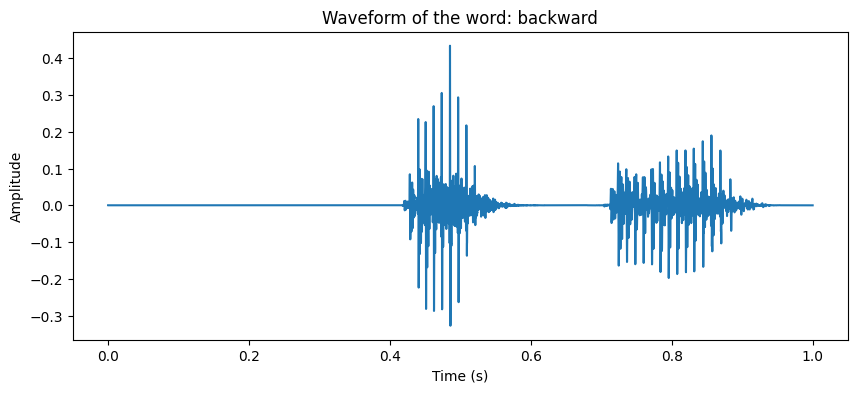

In [74]:
waveform, sample, label = train_trigger_samples[20]
waveform_np = waveform.numpy().squeeze() # turn it into 1D instead of 2D to plot

plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(waveform_np)/16000, len(waveform_np)), waveform_np)
plt.title(f"Waveform of the word: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [75]:
ipd.Audio(waveform, rate=16000)

In [11]:
def generate_and_label_spectrogram(waveform, label, target_length=101, n_fft=400, win_len=400, hop_len=160, n_mels=128, sample_rate=16000):
    # Create Mel Spectrogram
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        n_mels=n_mels
    )(waveform)

    # Convert to dB
    mel_spec_db = T.AmplitudeToDB()(mel_spectrogram)

    # Check the current number of frames in the spectrogram
    num_frames = mel_spec_db.shape[-1]

    # Pad the spectrogram if it is less than the target length
    if num_frames < target_length:
        # Calculate the amount of padding needed
        padding_size = target_length - num_frames
        # Create a padding tensor of zeros with the same number of channels as the spectrogram
        padding = torch.zeros((mel_spec_db.shape[0], mel_spec_db.shape[1], padding_size))
        # Concatenate the padding to the spectrogram along the time dimension (columns)
        mel_spec_db = torch.cat((mel_spec_db, padding), dim=2)

    # Generate labels based on the input label
    if label == 'backward':
        labels = np.ones((target_length,))
    else:
        labels = np.zeros((target_length,))

    return mel_spec_db, labels

In [12]:
train_spectrogram_data = []
train_labels_data = []
val_spectrogram_data = []
val_labels_data = []

for waveform, sample_rate, label in train_trigger_samples + train_non_trigger_samples:
    spec, lbls = generate_and_label_spectrogram(waveform, label)
    train_spectrogram_data.append(spec)
    train_labels_data.append(lbls)

for waveform, sample_rate, label in val_trigger_samples + val_non_trigger_samples:
    spec, lbls = generate_and_label_spectrogram(waveform, label)
    val_spectrogram_data.append(spec)
    val_labels_data.append(lbls)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [13]:
print(np.array(train_spectrogram_data).shape)
print(np.array(train_labels_data).shape)
print(np.array(val_spectrogram_data).shape)
print(np.array(val_labels_data).shape)

(4001, 1, 128, 101)
(4001, 101)
(999, 1, 128, 101)
(999, 101)


In [14]:
class TriggerWordGRUModel(nn.Module):
    def __init__(self):
        super(TriggerWordGRUModel, self).__init__()
        # Convolutional layer processes the features along the time dimension
        self.conv1 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=5, padding=2)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

        # First GRU layer
        self.gru1 = nn.GRU(input_size=64, hidden_size=128, num_layers=1, batch_first=True)

        # Second GRU layer
        self.gru2 = nn.GRU(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

        # Linear layers
        self.linear = nn.Linear(128, 1)  # Reducing dimension before final classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Correcting input shape to (batch, channels, time)
        x = x.transpose(1, 2)  # Now shape (batch, features, time)

        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Transpose for GRU (batch, time, features)
        x = x.transpose(1, 2)  # Now shape (batch, time, features)

        x, _ = self.gru1(x)
        x = self.dropout(x)

        x, _ = self.gru2(x)
        x = self.dropout(x)

        x = self.linear(x)
        x = self.sigmoid(x)

        return x.squeeze(-1)

In [15]:
model = TriggerWordGRUModel()

In [16]:
spectrogram_tensor = torch.stack([s.squeeze(0).transpose(0,1) for s in train_spectrogram_data]) # now [batch, time, frequenzy]
labels_tensor = torch.Tensor(train_labels_data)

#create dataset and loader
dataset = TensorDataset(spectrogram_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Assuming val_spectrogram_data and val_labels_data are already lists of tensors
val_spectrogram_tensor = torch.stack([s.squeeze(0).transpose(0,1) for s in val_spectrogram_data])
val_labels_tensor = torch.Tensor(val_labels_data)

# Create the validation dataset and dataloader
val_dataset = TensorDataset(val_spectrogram_tensor, val_labels_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

<ipython-input-16-13c889985b7b>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  labels_tensor = torch.Tensor(train_labels_data)


In [76]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs=15):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        for spectrograms, labels in train_dataloader:
            # Forward pass
            outputs = model(spectrograms)
            loss = loss_fn(outputs, labels)
            train_loss += loss.item()

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to avoid explosion
            optimizer.step()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():  # Turn off gradients for validation to save memory and computations
            for spectrograms, labels in val_dataloader:
                outputs = model(spectrograms)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

        # Print average losses for the current epoch
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    print('Training Finished')

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
train_model(model, dataloader, val_dataloader, loss_fn, optimizer)

Epoch [1/15], Train Loss: 0.6702, Val Loss: 0.6745
Epoch [2/15], Train Loss: 0.6701, Val Loss: 0.6748
Epoch [3/15], Train Loss: 0.6704, Val Loss: 0.6734
Epoch [4/15], Train Loss: 0.6702, Val Loss: 0.6741
Epoch [5/15], Train Loss: 0.6703, Val Loss: 0.6744
Epoch [6/15], Train Loss: 0.6703, Val Loss: 0.6737
Epoch [7/15], Train Loss: 0.6704, Val Loss: 0.6732
Epoch [8/15], Train Loss: 0.6699, Val Loss: 0.6727
Epoch [9/15], Train Loss: 0.6687, Val Loss: 0.6750
Epoch [10/15], Train Loss: 0.6704, Val Loss: 0.6736
Epoch [11/15], Train Loss: 0.6699, Val Loss: 0.6726
Epoch [12/15], Train Loss: 0.6694, Val Loss: 0.6721
Epoch [13/15], Train Loss: 0.6686, Val Loss: 0.6725
Epoch [14/15], Train Loss: 0.6688, Val Loss: 0.6720
Epoch [15/15], Train Loss: 0.6677, Val Loss: 0.6732
Training Finished


In [23]:
model.eval()

# Prepare the single spectrogram data example
# `spectrogram_data[0]` is assumed to be of shape [1, 128, 101] (1 for batch size)
single_spectrogram = val_spectrogram_tensor[20].unsqueeze(0)

# Check the shape
print("Shape of the input spectrogram:", single_spectrogram.shape)

# Ensure it's on the correct device
device = next(model.parameters()).device
single_spectrogram = single_spectrogram.to(device)

# Make prediction
with torch.no_grad():
    prediction = model(single_spectrogram)

print("Prediction output:", prediction)

Shape of the input spectrogram: torch.Size([1, 101, 128])
Prediction output: tensor([[0.2061, 0.0473, 0.0147, 0.0072, 0.0049, 0.0041, 0.0037, 0.0037, 0.0036,
         0.0035, 0.0035, 0.0033, 0.0031, 0.0030, 0.0030, 0.0031, 0.0031, 0.0032,
         0.0032, 0.0032, 0.0032, 0.0032, 0.0031, 0.0029, 0.0027, 0.0027, 0.0027,
         0.0027, 0.0028, 0.0028, 0.0029, 0.0029, 0.0030, 0.0031, 0.0031, 0.0030,
         0.0030, 0.0030, 0.0030, 0.0030, 0.0031, 0.0032, 0.0033, 0.0034, 0.0034,
         0.0034, 0.0030, 0.0028, 0.0025, 0.0023, 0.0022, 0.0022, 0.0022, 0.0024,
         0.0026, 0.0029, 0.0034, 0.0041, 0.0050, 0.0061, 0.0070, 0.0081, 0.0096,
         0.0139, 0.0269, 0.0824, 0.2783, 0.6208, 0.8330, 0.9160, 0.9487, 0.9635,
         0.9707, 0.9741, 0.9752, 0.9745, 0.9717, 0.9668, 0.9590, 0.9484, 0.9313,
         0.9080, 0.8785, 0.8448, 0.7903, 0.7189, 0.6040, 0.4264, 0.2194, 0.0764,
         0.0233, 0.0094, 0.0052, 0.0037, 0.0032, 0.0030, 0.0030, 0.0029, 0.0028,
         0.0027, 0.0027]])


In [19]:
print(np.array(single_spectrogram).shape)

(1, 101, 128)


In [25]:
threshold = 0.5
binary_predictions = (prediction > threshold).int()
print(binary_predictions)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]], dtype=torch.int32)


In [26]:
single_label = val_labels_tensor[20]

In [27]:
single_label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [77]:
def load_audio(file_path, target_sample_rate=16000):
  audio, sample_rate = librosa.load(file_path, sr=target_sample_rate)
  return audio, sample_rate

audio, sample_rate = load_audio('/content/ttsmaker-file-2024-8-28-21-17-14.mp3')

In [57]:
audio2, sample_rate2 = load_audio('/content/Recording (2).m4a')

<ipython-input-28-03469256947f>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, sr=target_sample_rate)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [53]:
def create_spectrogram(waveform, n_fft=400, win_len=400, hop_len=160, n_mels=128, sample_rate=16000):
    waveform = torch.tensor(waveform).float()
    if waveform.ndim == 1:  # Add channel dimension if mono
        waveform = waveform.unsqueeze(0)

    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        n_mels=n_mels
    )(waveform)

    mel_spec_db = T.AmplitudeToDB()(mel_spectrogram)
    return mel_spec_db

In [78]:
spectrogram = create_spectrogram(audio)
spectrogram = spectrogram.transpose(2,1)


model.eval()
device = next(model.parameters()).device
spectrogram = spectrogram.to(device)

with torch.no_grad():
    prediction1 = model(spectrogram)
    binary_predictions1 = (prediction1 > threshold).int()

print("Prediction:", binary_predictions1)

Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


In [79]:
spectrogram2 = create_spectrogram(audio2)
spectrogram2 = spectrogram2.transpose(2,1)


model.eval()
device = next(model.parameters()).device
spectrogram2 = spectrogram2.to(device)

with torch.no_grad():
    prediction2 = model(spectrogram2)
    binary_predictions2 = (prediction2 > threshold).int()
print("Prediction:", binary_predictions2)

Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=torch.int32)


In [80]:
torch.save(model, 'Trigger_word_detection_model.pth')